# Wikipedia pages graph from seed page

In [18]:
from operator import itemgetter
import networkx as nx
import wikipedia
from wikipedia import DisambiguationError, PageError
import matplotlib.pyplot as plt

Set the seed page and the search depth. The search depth is the number of
layers of neighbors to include in the network. e.g., if the search depth is 1,
the network will include the seed page and all pages linked from the seed page.

In [19]:
SEARCH_DEPTH = 1  #Set the search depth here                       
SEED = "stone"  #Set the seed page here

STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "Geographic coordinate system",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier",
         "Pubmed Central",
         "Digital Object Identifier",
         "Arxiv",
         "Proc Natl Acad Sci Usa",
         "Bibcode",
         "Library Of Congress Control Number",
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")


## 1.1 Setting up fringe and visited sets

In [20]:
SEED = SEED.title()
fringe = [(0, SEED)]  # The queue of pages we have found but not yet visited
done_set = set()  # The set of pages we have visited
g = nx.DiGraph()  # The networkx graph, directed


## 1.2 Load the seed page
Check whether the seed page exists.

In [21]:
import sys

layer, page = 0, SEED

try:
    source = wikipedia.page(SEED, auto_suggest=False)
    done_set.add(SEED)
    print(source.url)
    print(f"Page loaded, adding {len(source.links)} subpages")
except (DisambiguationError, PageError):
    print(f"Could not load seed {SEED}")
    print("Check if the page exists.")
    sys.exit(1)

https://en.wikipedia.org/wiki/Rock_(geology)
Page loaded, adding 274 subpages


## 1.3 Build the network
Using Breadth First Search (BFS) to build the network.

In [22]:
%%time

progress = {"nodes": [], "fringe": [], "layer": []}

while fringe:
    
    print(f"{layer} - {page}, nodes: {len(done_set)}, fringe: {len(fringe)}")
    layer, page = fringe.pop(0)
    progress["nodes"].append(len(done_set))
    progress["fringe"].append(len(fringe))
    progress["layer"].append(layer)
    
    try:
        links = wikipedia.page(page).links
    except (DisambiguationError, PageError):
        print(f"Error retrieving links from {page}")
        continue

    for link in links:
        g.add_edge(page, link)
        if link not in STOPS and link not in done_set and not link.startswith("List of"):
            done_set.add(link)
            if layer < SEARCH_DEPTH:
                fringe.append((layer + 1, link))


0 - Stone, nodes: 1, fringe: 1
0 - Stone, nodes: 272, fringe: 271
Error retrieving links from 4 Vesta
1 - 4 Vesta, nodes: 272, fringe: 270
1 - Agriculture, nodes: 996, fringe: 269
1 - Alkali metal oxide, nodes: 1047, fringe: 268
Error retrieving links from Ancient Rome
1 - Ancient Rome, nodes: 1047, fringe: 267
1 - Anthropic rock, nodes: 1068, fringe: 266
1 - Archaeology, nodes: 1914, fringe: 265
1 - Arkose, nodes: 2087, fringe: 264
1 - Artificial stone, nodes: 2169, fringe: 263
1 - Asteroid, nodes: 3103, fringe: 262
1 - Asthenosphere, nodes: 3153, fringe: 261
1 - Balancing rock, nodes: 3244, fringe: 260


/home/marco/anaconda3/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/marco/anaconda3/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Error retrieving links from Basalt
1 - Basalt, nodes: 3244, fringe: 259
1 - Base metals, nodes: 3434, fringe: 258
1 - Bibcode (identifier), nodes: 3443, fringe: 257
1 - Boulder, nodes: 3454, fringe: 256
1 - Bowen's reaction series, nodes: 3472, fringe: 255
1 - Building material, nodes: 3792, fringe: 254
1 - Cairn, nodes: 4681, fringe: 253
Error retrieving links from Carbonation
1 - Carbonation, nodes: 4681, fringe: 252
1 - Cementation (geology), nodes: 4696, fringe: 251
1 - Charles Steen, nodes: 5062, fringe: 250
1 - Chemical bond, nodes: 5399, fringe: 249
1 - Chemical compound, nodes: 5464, fringe: 248
1 - Chemical synthesis, nodes: 6019, fringe: 247
1 - Clastic, nodes: 6072, fringe: 246
1 - Clastic rock, nodes: 6365, fringe: 245
Error retrieving links from Clay
1 - Clay, nodes: 6365, fringe: 244
1 - Coade stone, nodes: 6722, fringe: 243
1 - Coal, nodes: 6749, fringe: 242
1 - Cobble (geology), nodes: 6902, fringe: 241
1 - Concrete, nodes: 7384, fringe: 240
1 - Construction aggregate, 

KeyboardInterrupt: 

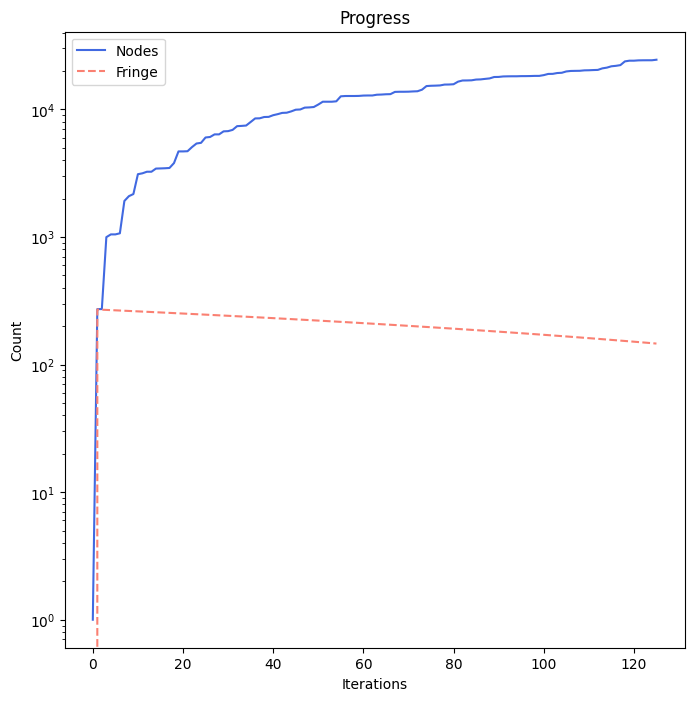

In [23]:
#plotting the progress
plt.figure("Progress", figsize=(8, 8))
plt.plot(progress["nodes"], label="Nodes", color="royalblue", linestyle="-")
plt.plot(progress["fringe"], label="Fringe", color="salmon", linestyle="--")
# log scale
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Count")
plt.title("Progress")
plt.legend()
plt.show()


In [24]:
print(f"{g.number_of_nodes()} nodes, {g.number_of_edges()} edges")

24897 nodes, 37720 edges


## 1.4 Explore the network

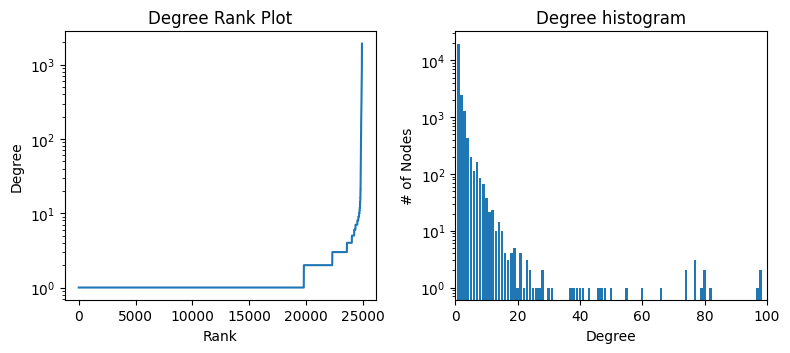

In [25]:
import numpy as np

degree_sequence = sorted((d for _, d in g.degree()))

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence)
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_yscale("log")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_xlim([0, 100])
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_yscale("log")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## 1.5 Save the graph in Gephi readable format

In [26]:
nx.write_gexf(g, f"graphs/{SEED}_d{SEARCH_DEPTH}.gexf")